In [1]:
!pip install xgboost
!pip install shap
!pip install explainerdashboard
!pip install --upgrade fairlearn==0.7.0 raiwidgets

# Dateset:
- https://www.kaggle.com/saniyajaswani/credit-card-data

In [2]:
# import all modules
from pathlib import Path
from google.colab import drive

import pandas as pd #we use this to load, read and transform the dataset
import numpy as np #we use this for statistical analysis
import matplotlib.pyplot as plt #we use this to visualize the dataset

import seaborn as sns #we use this to make countplots
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder # scale numeric features
from sklearn.model_selection import train_test_split # train test split data

from sklearn.metrics import (accuracy_score, 
                             roc_auc_score, 
                             precision_score, 
                             recall_score)

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn import metrics

import shap

from explainerdashboard import ClassifierExplainer, ExplainerDashboard

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`

The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`


In [3]:
# let´s mount the some folders for e.g. training data and models etc.
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
# create data and model folders
MODELPATH = "gdrive/MyDrive/CLV_RAI/models"
DATAPATH = "gdrive/MyDrive/CLV_RAI/data"
DASHBOARDPATH = "gdrive/MyDrive/CLV_RAI/dashboard"

Path(MODELPATH).mkdir(parents=True, exist_ok=True)
Path(DATAPATH).mkdir(parents=True, exist_ok=True)
Path(DASHBOARDPATH).mkdir(parents=True, exist_ok=True)

In [5]:
df = pd.read_csv(DATAPATH / Path('cltv_bank.csv'))
df.head()

,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,...,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/11,Employed,F,56274,...,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/11,Unemployed,F,0,...,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/11,Employed,F,48767,...,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,WW63253,California,7645.861827,No,Basic,Bachelor,1/20/11,Unemployed,M,0,...,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,HB64268,Washington,2813.692575,No,Basic,Bachelor,2/3/11,Employed,M,43836,...,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


In [6]:
# is the customer id unique?
print('df got {} datasets'.format(df.shape[0]))
print('df got {} unique customers'.format(df.Customer.unique().shape[0]))

df got 9134 datasets
df got 9134 unique customers


In [7]:
# check missing values
df.isnull().sum()

Customer                         0
State                            0
Customer Lifetime Value          0
Response                         0
Coverage                         0
Education                        0
Effective To Date                0
EmploymentStatus                 0
Gender                           0
Income                           0
Location Code                    0
Marital Status                   0
Monthly Premium Auto             0
Months Since Last Claim          0
Months Since Policy Inception    0
Number of Open Complaints        0
Number of Policies               0
Policy Type                      0
Policy                           0
Renew Offer Type                 0
Sales Channel                    0
Total Claim Amount               0
Vehicle Class                    0
Vehicle Size                     0
dtype: int64

In [8]:
# what type of data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9134 entries, 0 to 9133
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Customer                       9134 non-null   object 
 1   State                          9134 non-null   object 
 2   Customer Lifetime Value        9134 non-null   float64
 3   Response                       9134 non-null   object 
 4   Coverage                       9134 non-null   object 
 5   Education                      9134 non-null   object 
 6   Effective To Date              9134 non-null   object 
 7   EmploymentStatus               9134 non-null   object 
 8   Gender                         9134 non-null   object 
 9   Income                         9134 non-null   int64  
 10  Location Code                  9134 non-null   object 
 11  Marital Status                 9134 non-null   object 
 12  Monthly Premium Auto           9134 non-null   i

# Define Feature Types and Target

In [9]:
target = ['Customer Lifetime Value']
target_cat = ['CLV_cat']

numeric_features = ['Income', 
                    'Monthly Premium Auto', 
                    'Months Since Last Claim', 
                    'Months Since Policy Inception', 
                    'Number of Open Complaints', 
                    'Number of Policies', 
                    'Total Claim Amount']

cat_features = ['State', 'Response', 'Coverage', 'Education', 'EmploymentStatus', 
                'Policy Type', 'Policy', 'Renew Offer Type', 'Sales Channel', 'Vehicle Class', 'Vehicle Size',
                'Gender', 'Marital Status', 'Location Code']

sensitive_features = ['Gender'] # we try to avoid any unfair model behavior along gender, marital status or location code

In [10]:
# reorder columns
df = df[numeric_features + cat_features + target]


In [11]:
df.head()

,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount,State,Response,Coverage,...,Policy Type,Policy,Renew Offer Type,Sales Channel,Vehicle Class,Vehicle Size,Gender,Marital Status,Location Code,Customer Lifetime Value
0,56274,69,32,5,0,1,384.811147,Washington,No,Basic,...,Corporate Auto,Corporate L3,Offer1,Agent,Two-Door Car,Medsize,F,Married,Suburban,2763.519279
1,0,94,13,42,0,8,1131.464935,Arizona,No,Extended,...,Personal Auto,Personal L3,Offer3,Agent,Four-Door Car,Medsize,F,Single,Suburban,6979.535903
2,48767,108,18,38,0,2,566.472247,Nevada,No,Premium,...,Personal Auto,Personal L3,Offer1,Agent,Two-Door Car,Medsize,F,Married,Suburban,12887.431650
3,0,106,18,65,0,7,529.881344,California,No,Basic,...,Corporate Auto,Corporate L2,Offer1,Call Center,SUV,Medsize,M,Married,Suburban,7645.861827
4,43836,73,12,44,0,1,138.130879,Washington,No,Basic,...,Personal Auto,Personal L1,Offer1,Agent,Four-Door Car,Medsize,M,Single,Rural,2813.692575


# Lets do EDA on numeric features first

In [12]:
df[numeric_features].head()

,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount
0,56274,69,32,5,0,1,384.811147
1,0,94,13,42,0,8,1131.464935
2,48767,108,18,38,0,2,566.472247
3,0,106,18,65,0,7,529.881344
4,43836,73,12,44,0,1,138.130879


In [13]:
# descriptive statistics for numeric data
df.describe()

,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount,Customer Lifetime Value
count,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000
mean,37657.380009,93.219291,15.097000,48.064594,0.384388,2.966170,434.088794,8004.940475
std,30379.904734,34.407967,10.073257,27.905991,0.910384,2.390182,290.500092,6870.967608
min,0.000000,61.000000,0.000000,0.000000,0.000000,1.000000,0.099007,1898.007675
25%,0.000000,68.000000,6.000000,24.000000,0.000000,1.000000,272.258244,3994.251794
50%,33889.500000,83.000000,14.000000,48.000000,0.000000,2.000000,383.945434,5780.182197
75%,62320.000000,109.000000,23.000000,71.000000,0.000000,4.000000,547.514839,8962.167041
max,99981.000000,298.000000,35.000000,99.000000,5.000000,9.000000,2893.239678,83325.381190


# Lets encode the target column as a binary variable
- Encoding: customer below or equal 50% quantile: poor CLV labeled as 0
- Encoding: customer above 50% quantile: excelent CLV labeled as 1

In [14]:
df.loc[np.array(df[target] <= df[target].quantile(q=0.50)).reshape(-1) , target_cat] = int(0.0)
df.loc[np.array(df[target] > df[target].quantile(q=0.50)).reshape(-1) , target_cat] = int(1.0)

In [15]:
df.head()

,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount,State,Response,Coverage,...,Policy,Renew Offer Type,Sales Channel,Vehicle Class,Vehicle Size,Gender,Marital Status,Location Code,Customer Lifetime Value,CLV_cat
0,56274,69,32,5,0,1,384.811147,Washington,No,Basic,...,Corporate L3,Offer1,Agent,Two-Door Car,Medsize,F,Married,Suburban,2763.519279,0.0
1,0,94,13,42,0,8,1131.464935,Arizona,No,Extended,...,Personal L3,Offer3,Agent,Four-Door Car,Medsize,F,Single,Suburban,6979.535903,1.0
2,48767,108,18,38,0,2,566.472247,Nevada,No,Premium,...,Personal L3,Offer1,Agent,Two-Door Car,Medsize,F,Married,Suburban,12887.431650,1.0
3,0,106,18,65,0,7,529.881344,California,No,Basic,...,Corporate L2,Offer1,Call Center,SUV,Medsize,M,Married,Suburban,7645.861827,1.0
4,43836,73,12,44,0,1,138.130879,Washington,No,Basic,...,Personal L1,Offer1,Agent,Four-Door Car,Medsize,M,Single,Rural,2813.692575,0.0


In [16]:
# what about pearson correlation?
df[target_cat + numeric_features].corr()

,CLV_cat,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount
CLV_cat,1.000000,0.019628,0.364760,-0.005498,0.001766,-0.028891,0.217901,0.203087
Income,0.019628,1.000000,-0.016665,-0.026715,-0.000875,0.006408,-0.008656,-0.355254
Monthly Premium Auto,0.364760,-0.016665,1.000000,0.005026,0.020257,-0.013122,-0.011233,0.632017
Months Since Last Claim,-0.005498,-0.026715,0.005026,1.000000,-0.042959,0.005354,0.009136,0.007563
Months Since Policy Inception,0.001766,-0.000875,0.020257,-0.042959,1.000000,-0.001158,-0.013333,0.003335
Number of Open Complaints,-0.028891,0.006408,-0.013122,0.005354,-0.001158,1.000000,0.001498,-0.014241
Number of Policies,0.217901,-0.008656,-0.011233,0.009136,-0.013333,0.001498,1.000000,-0.002354
Total Claim Amount,0.203087,-0.355254,0.632017,0.007563,0.003335,-0.014241,-0.002354,1.000000


Apparently we see some noticeable correlation between CLV, monthly premium auto and total claim amount

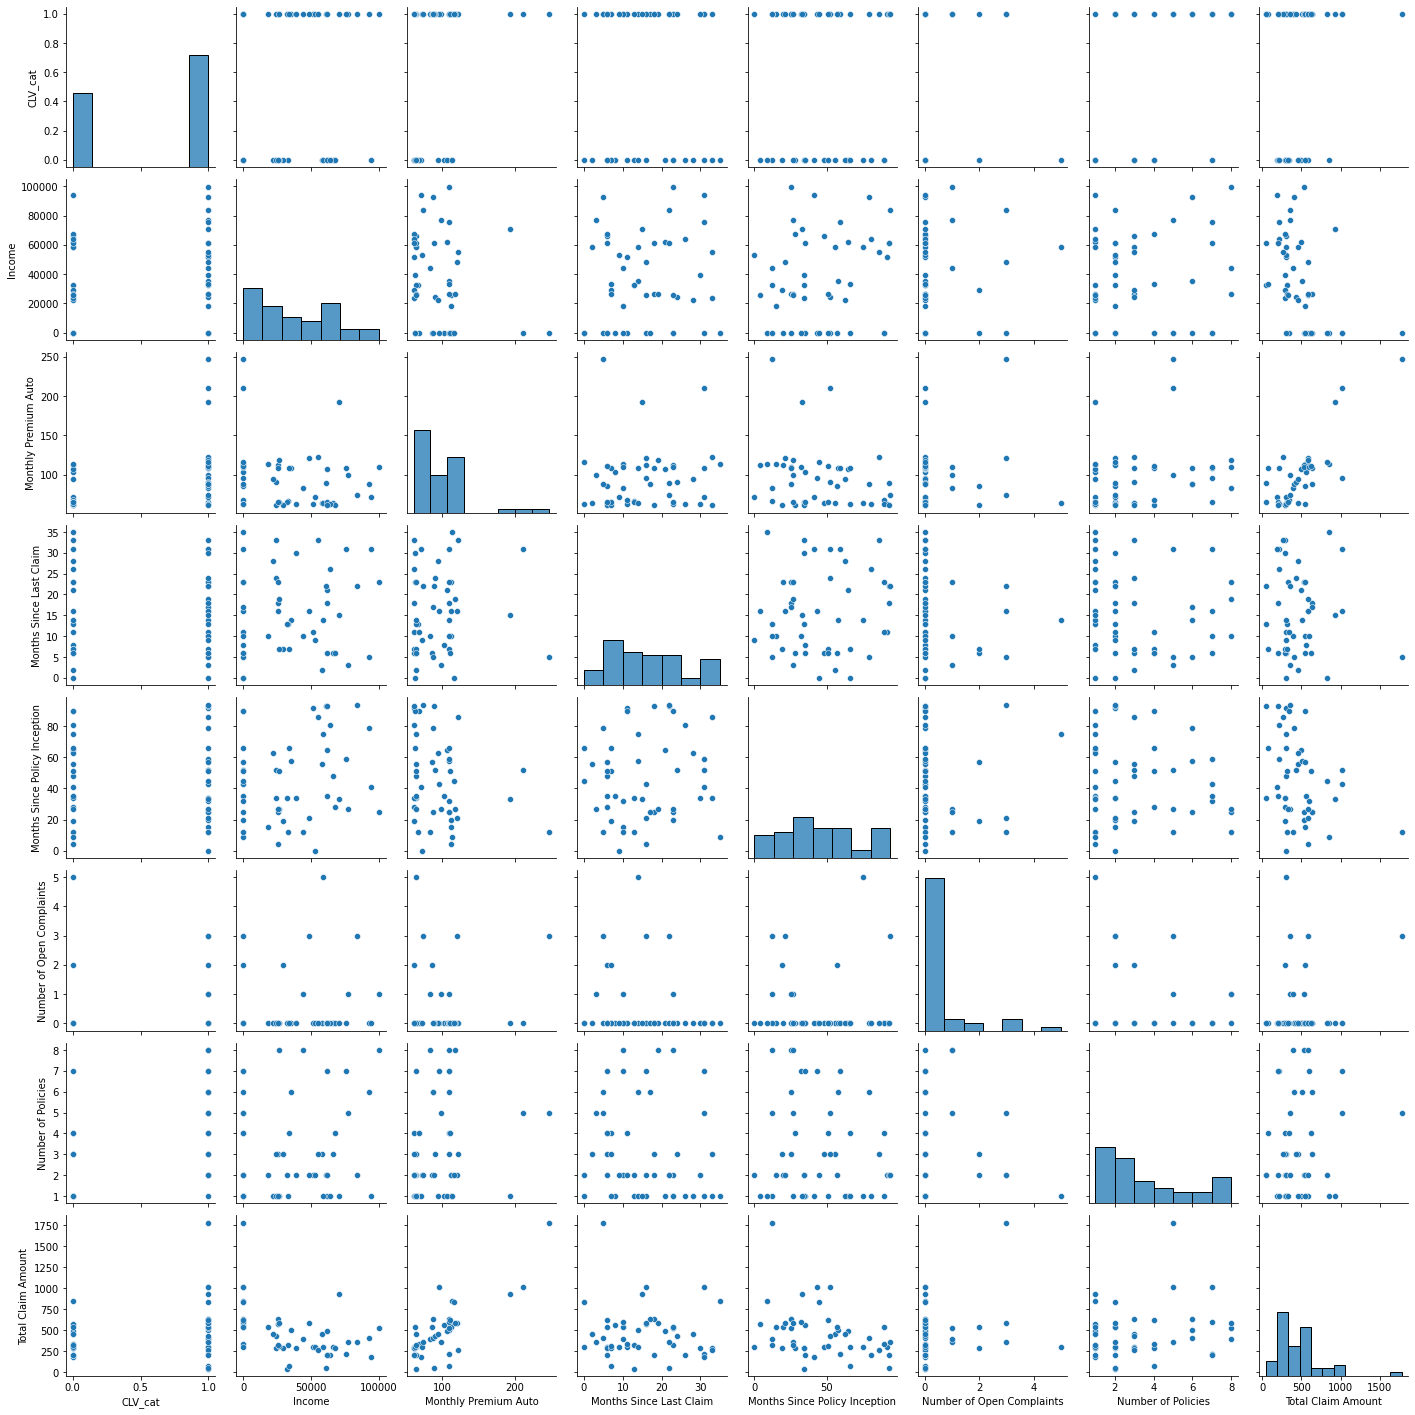

In [17]:
# lets have a look
sns.pairplot(df[target_cat+numeric_features].sample(50))
plt.show()

so far, the chances are pretty low that we get some good CLV prediction by using the weakly correlated numeric data only (which I was hoping :-) )
so let´s go about the categorical data and hope for something good to happen ;-)

# Lets do EDA on categorical features

In [18]:
df[target_cat + cat_features].head()

,CLV_cat,State,Response,Coverage,Education,EmploymentStatus,Policy Type,Policy,Renew Offer Type,Sales Channel,Vehicle Class,Vehicle Size,Gender,Marital Status,Location Code
0,0.0,Washington,No,Basic,Bachelor,Employed,Corporate Auto,Corporate L3,Offer1,Agent,Two-Door Car,Medsize,F,Married,Suburban
1,1.0,Arizona,No,Extended,Bachelor,Unemployed,Personal Auto,Personal L3,Offer3,Agent,Four-Door Car,Medsize,F,Single,Suburban
2,1.0,Nevada,No,Premium,Bachelor,Employed,Personal Auto,Personal L3,Offer1,Agent,Two-Door Car,Medsize,F,Married,Suburban
3,1.0,California,No,Basic,Bachelor,Unemployed,Corporate Auto,Corporate L2,Offer1,Call Center,SUV,Medsize,M,Married,Suburban
4,0.0,Washington,No,Basic,Bachelor,Employed,Personal Auto,Personal L1,Offer1,Agent,Four-Door Car,Medsize,M,Single,Rural


In [19]:
target_cat+cat_features

['CLV_cat',
 'State',
 'Response',
 'Coverage',
 'Education',
 'EmploymentStatus',
 'Policy Type',
 'Policy',
 'Renew Offer Type',
 'Sales Channel',
 'Vehicle Class',
 'Vehicle Size',
 'Gender',
 'Marital Status',
 'Location Code']

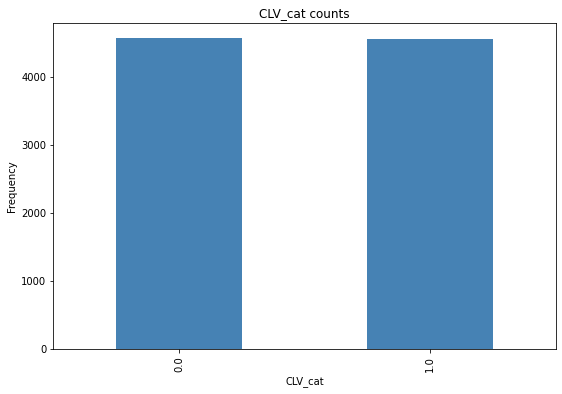

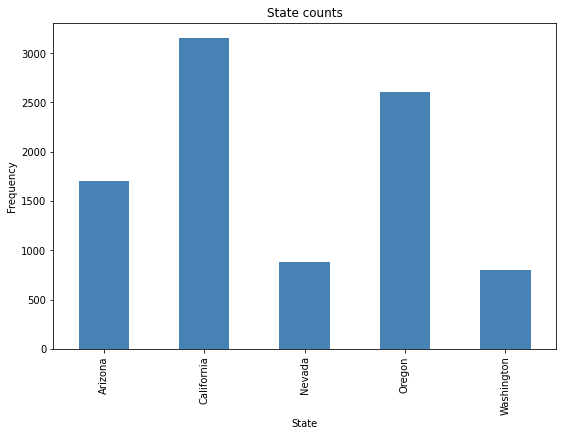

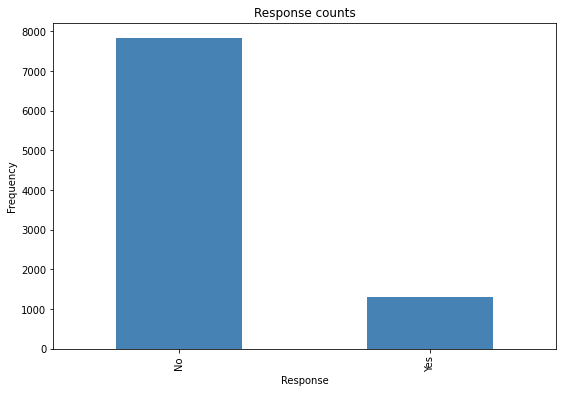

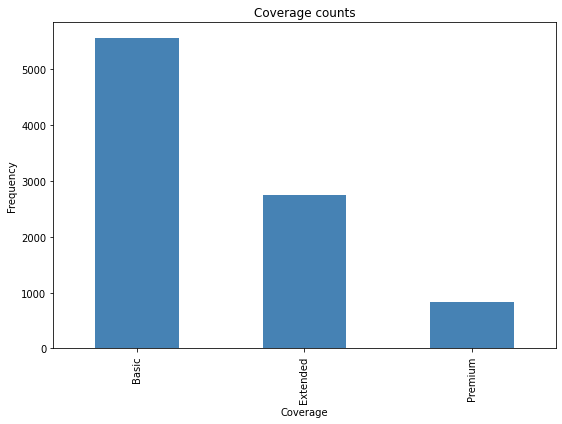

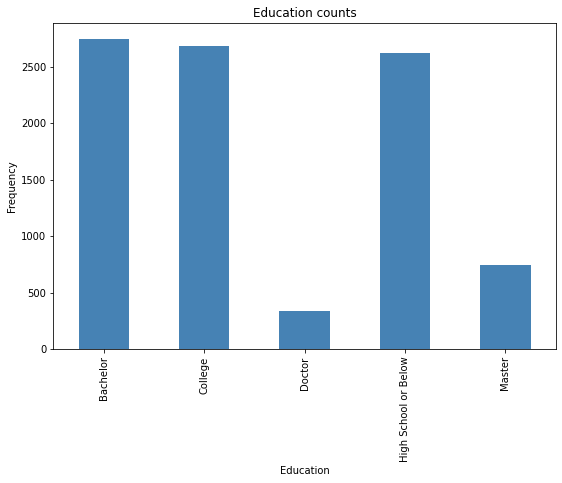

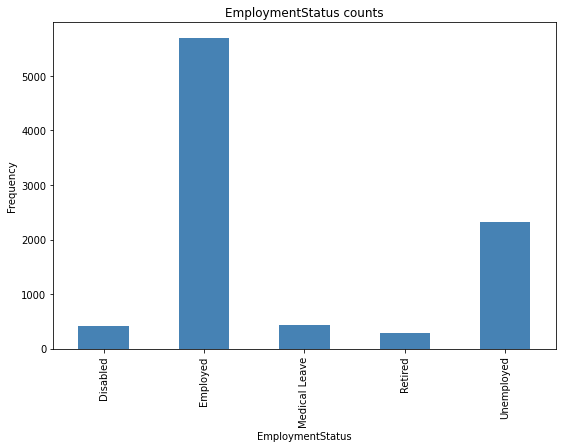

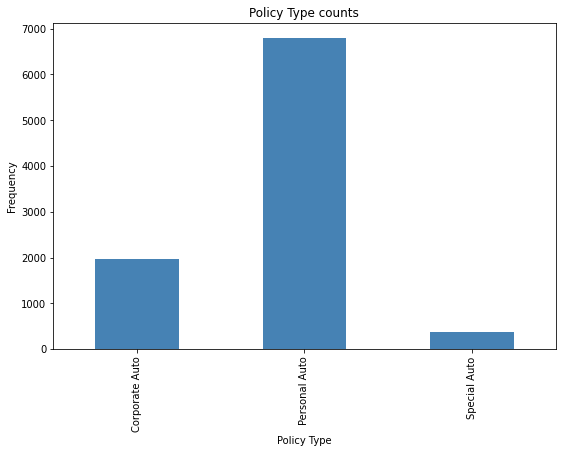

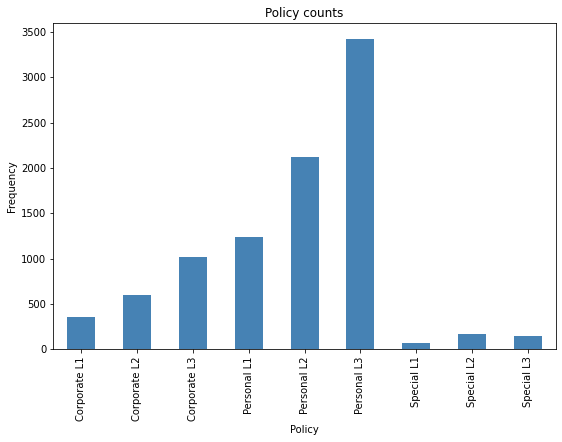

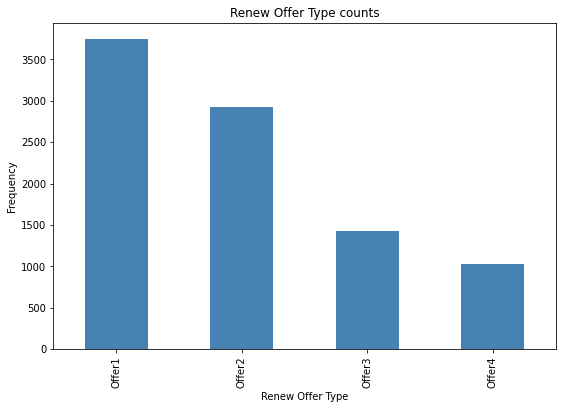

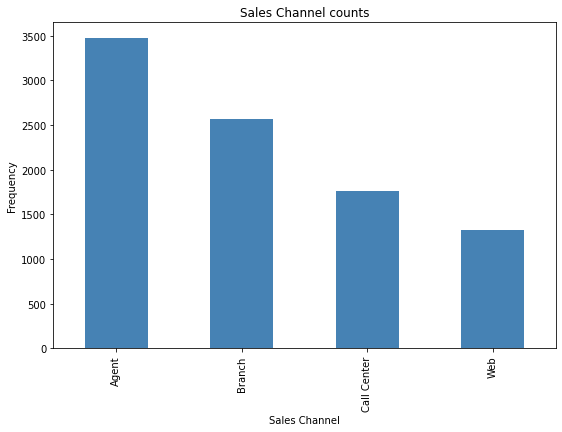

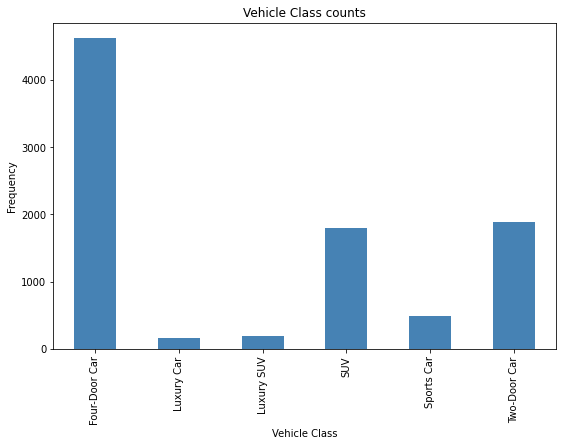

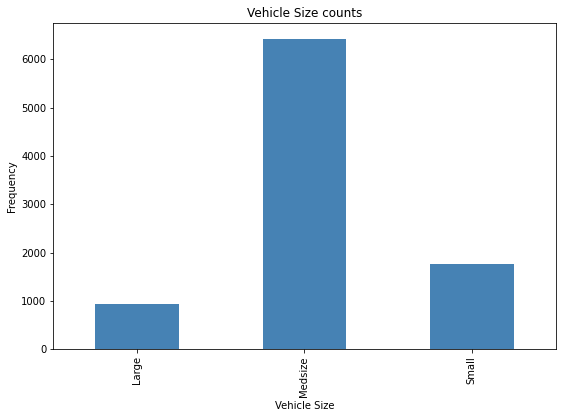

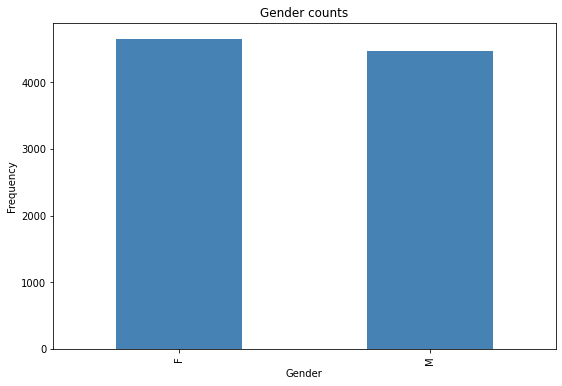

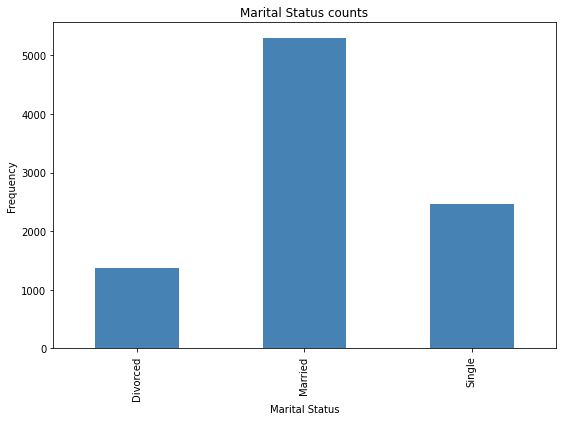

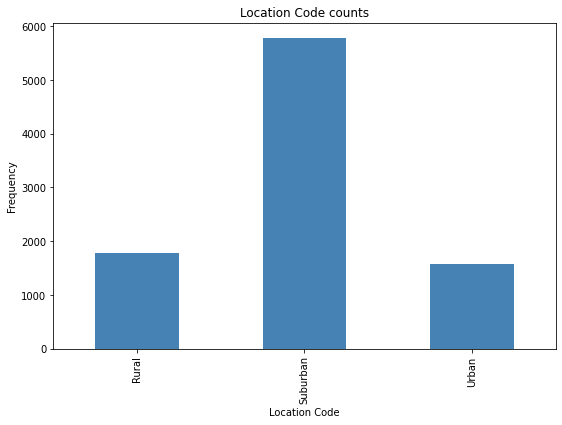

In [20]:
# plot a bar plot for each categorical feature count
for col in target_cat+cat_features:
    counts = df[col].value_counts().sort_index()
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    counts.plot.bar(ax = ax, color='steelblue')
    ax.set_title(col + ' counts')
    ax.set_xlabel(col) 
    ax.set_ylabel("Frequency")
plt.show()

With respect to the sensitive feature employment status, we dont want e.g. disabled people to be scored unfairly. With respect to the sensitive feature gender, we dont want male, female to be scored differently etc..

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


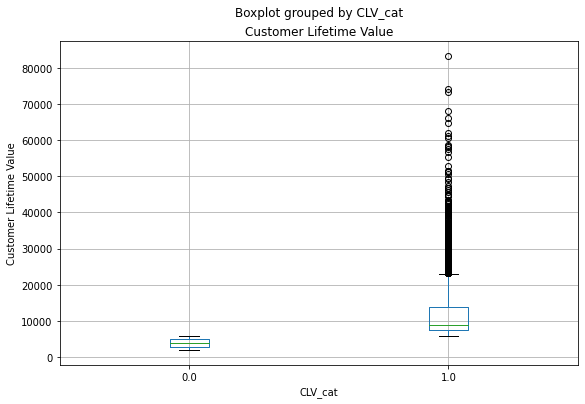

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


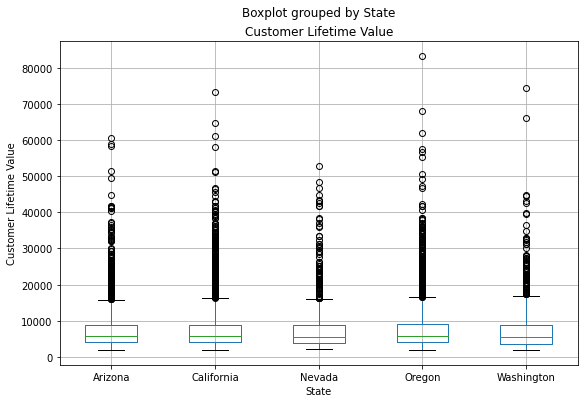

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


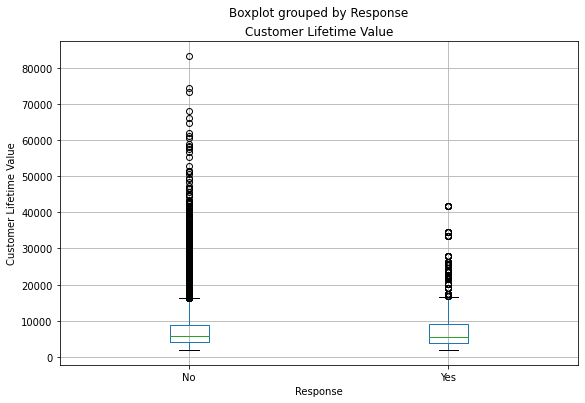

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


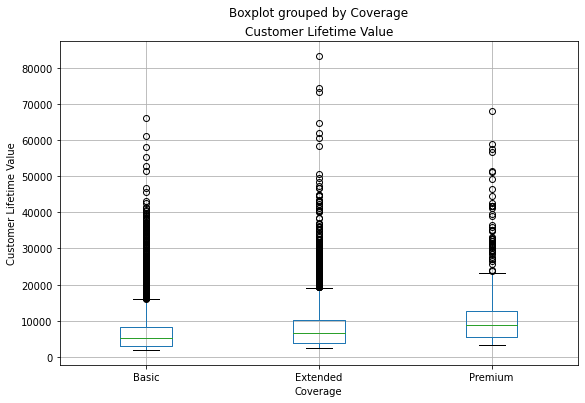

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


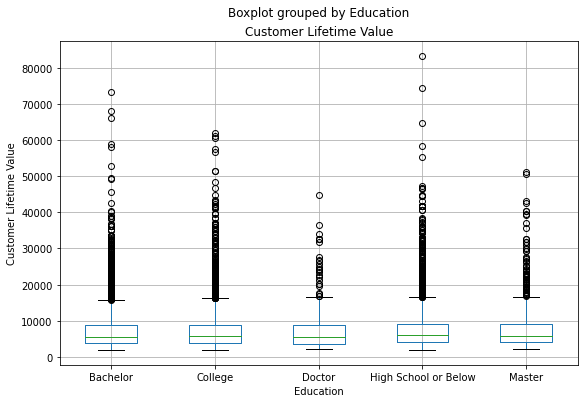

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


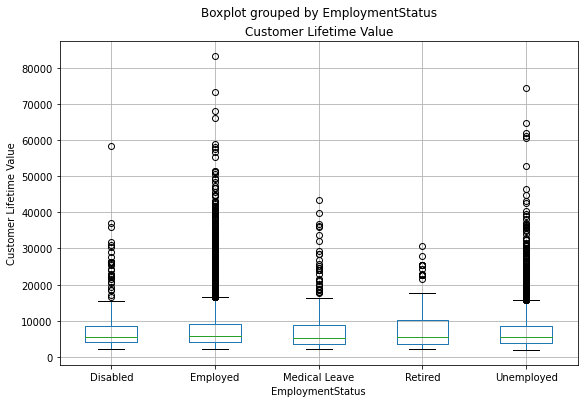

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


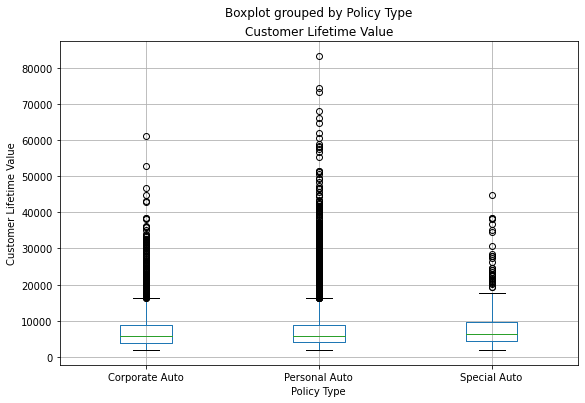

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


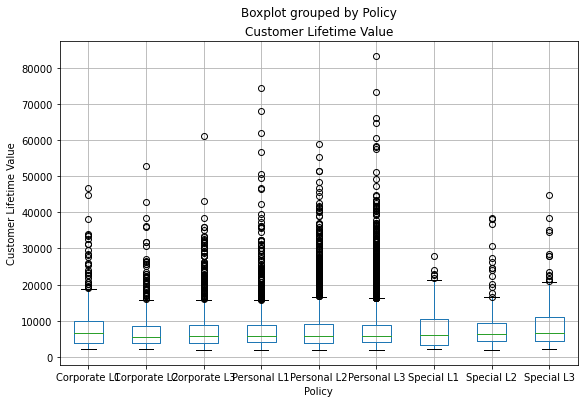

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


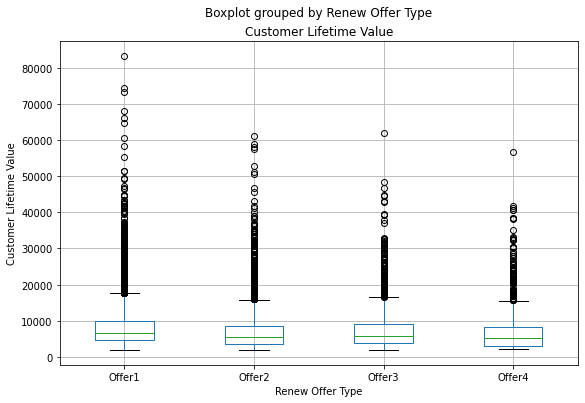

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


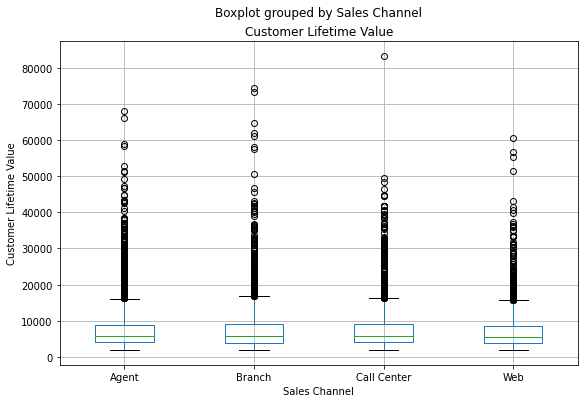

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


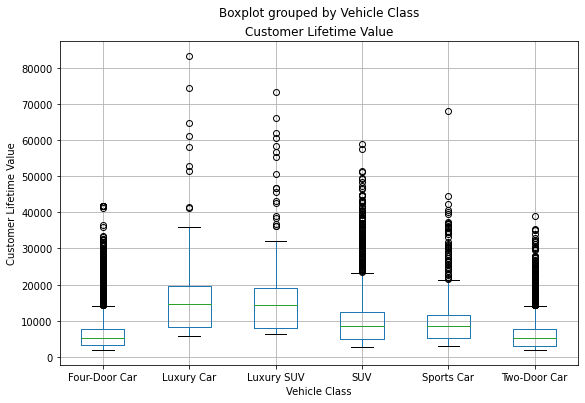

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


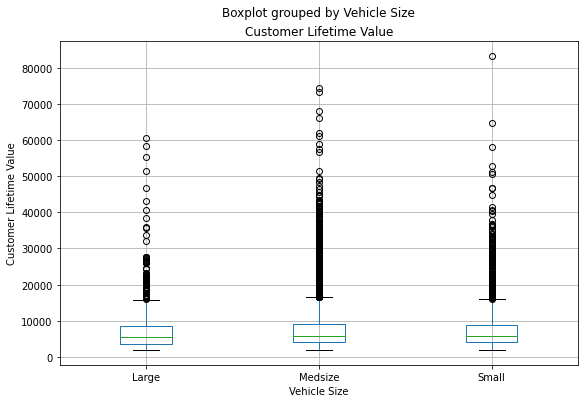

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


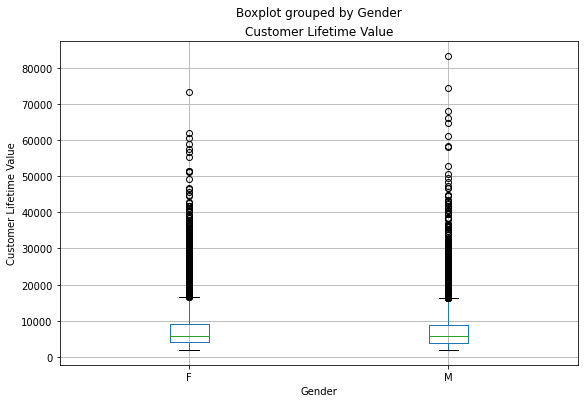

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


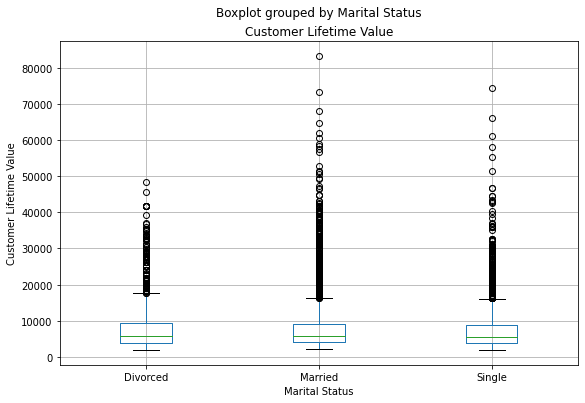

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


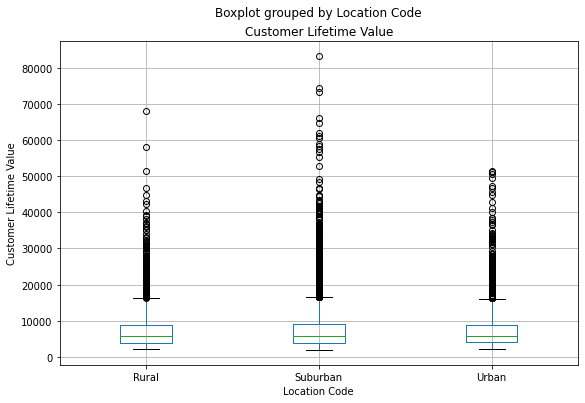

In [21]:
# plot a boxplot for the label by each categorical feature
for feat in target_cat+cat_features:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    df.boxplot(column='Customer Lifetime Value', by = feat, ax = ax)
    ax.set_ylabel("Customer Lifetime Value")
    plt.show()

With respect to the features "coverage" and "vehicle class", we see some apparent effect on CLV.

# Train-Test Split

In [22]:
df.head()

,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount,State,Response,Coverage,...,Policy,Renew Offer Type,Sales Channel,Vehicle Class,Vehicle Size,Gender,Marital Status,Location Code,Customer Lifetime Value,CLV_cat
0,56274,69,32,5,0,1,384.811147,Washington,No,Basic,...,Corporate L3,Offer1,Agent,Two-Door Car,Medsize,F,Married,Suburban,2763.519279,0.0
1,0,94,13,42,0,8,1131.464935,Arizona,No,Extended,...,Personal L3,Offer3,Agent,Four-Door Car,Medsize,F,Single,Suburban,6979.535903,1.0
2,48767,108,18,38,0,2,566.472247,Nevada,No,Premium,...,Personal L3,Offer1,Agent,Two-Door Car,Medsize,F,Married,Suburban,12887.431650,1.0
3,0,106,18,65,0,7,529.881344,California,No,Basic,...,Corporate L2,Offer1,Call Center,SUV,Medsize,M,Married,Suburban,7645.861827,1.0
4,43836,73,12,44,0,1,138.130879,Washington,No,Basic,...,Personal L1,Offer1,Agent,Four-Door Car,Medsize,M,Single,Rural,2813.692575,0.0


In [23]:
# Separate features and labels
X, y = df[numeric_features + cat_features], df[target_cat].values
print('Features:',X[:3], '\nLabels:', y[:3], sep='\n')

Features:
   Income  Monthly Premium Auto  Months Since Last Claim  \
0   56274                    69                       32   
1       0                    94                       13   
2   48767                   108                       18   

   Months Since Policy Inception  Number of Open Complaints  \
0                              5                          0   
1                             42                          0   
2                             38                          0   

   Number of Policies  Total Claim Amount       State Response  Coverage  ...  \
0                   1          384.811147  Washington       No     Basic  ...   
1                   8         1131.464935     Arizona       No  Extended  ...   
2                   2          566.472247      Nevada       No   Premium  ...   

  EmploymentStatus     Policy Type        Policy Renew Offer Type  \
0         Employed  Corporate Auto  Corporate L3           Offer1   
1       Unemployed   Personal Aut

In [24]:
# Split data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.80, random_state=123, stratify=y)

print ('Training Set: %d rows\nTest Set: %d rows' % (X_train.shape[0], X_test.shape[0]))

Training Set: 1826 rows
Test Set: 7308 rows


# Label-Encoding Categorical Data


In [25]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

In [26]:
# init encoder
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=1000)
# fit encoder
enc.fit(X_train[cat_features])

OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=1000)

In [27]:
# transform data
X_train[cat_features] = enc.transform(X_train[cat_features])
X_train.head()

,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount,State,Response,Coverage,...,EmploymentStatus,Policy Type,Policy,Renew Offer Type,Sales Channel,Vehicle Class,Vehicle Size,Gender,Marital Status,Location Code
9025,72608,82,26,19,3,8,393.600000,1.0,1.0,1.0,...,1.0,1.0,4.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0
2182,62229,70,13,26,0,5,336.000000,1.0,0.0,0.0,...,1.0,1.0,4.0,2.0,0.0,5.0,1.0,0.0,0.0,1.0
1098,0,109,35,75,0,1,523.200000,3.0,0.0,2.0,...,4.0,1.0,4.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0
7686,36267,69,21,1,0,8,263.454037,3.0,0.0,0.0,...,1.0,1.0,3.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0
5047,57693,76,16,56,0,3,547.200000,1.0,1.0,1.0,...,1.0,1.0,5.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


# Transform Hold-Out Dataset

In [28]:
# transform data
X_test[cat_features] = enc.transform(X_test[cat_features])
X_test.head()

,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount,State,Response,Coverage,...,EmploymentStatus,Policy Type,Policy,Renew Offer Type,Sales Channel,Vehicle Class,Vehicle Size,Gender,Marital Status,Location Code
66,22547,112,7,60,0,3,537.600000,3.0,0.0,0.0,...,1.0,0.0,2.0,0.0,0.0,3.0,1.0,0.0,0.0,1.0
3911,0,67,33,19,0,4,577.385463,0.0,0.0,0.0,...,4.0,1.0,4.0,0.0,2.0,5.0,0.0,1.0,2.0,1.0
242,0,64,13,64,0,4,307.200000,3.0,0.0,0.0,...,4.0,0.0,2.0,0.0,1.0,0.0,2.0,0.0,0.0,1.0
699,77048,103,20,41,0,1,141.199465,4.0,0.0,0.0,...,1.0,1.0,3.0,1.0,0.0,3.0,1.0,1.0,1.0,0.0
6018,41671,136,15,30,0,2,570.388228,0.0,0.0,1.0,...,1.0,1.0,3.0,0.0,0.0,3.0,1.0,0.0,2.0,2.0


# Model Selection: LightGBM vs Boosted Tree

In [29]:
lgb_model = LGBMClassifier().fit(X_train, y_train.reshape(-1))
print (lgb_model)

LGBMClassifier()


In [30]:
from sklearn. metrics import classification_report

In [31]:
pred = lgb_model.predict(X_test).reshape(-1)
pred

array([1., 0., 0., ..., 0., 0., 1.])

In [32]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      3655
         1.0       0.99      0.99      0.99      3653

    accuracy                           0.99      7308
   macro avg       0.99      0.99      0.99      7308
weighted avg       0.99      0.99      0.99      7308



In [33]:
from sklearn.metrics import confusion_matrix

In [34]:
# Print the confusion matrix
mcm = confusion_matrix(y_test, pred)
print(mcm)

[[3614   41]
 [  40 3613]]


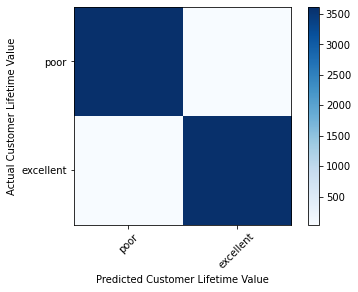

In [35]:
%matplotlib inline

clv_classes = ['poor', 'excellent']

plt.imshow(mcm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(clv_classes))
plt.xticks(tick_marks, clv_classes, rotation=45)
plt.yticks(tick_marks, clv_classes)
plt.xlabel("Predicted Customer Lifetime Value")
plt.ylabel("Actual Customer Lifetime Value")
plt.show()

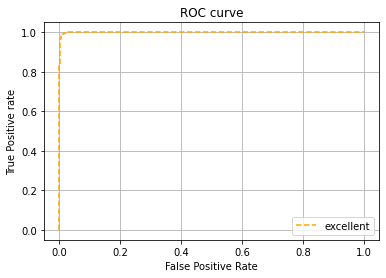

In [36]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# Get class probability scores
clv_prob = lgb_model.predict_proba(X_test)

# Get ROC metrics for each class
fpr = {}
tpr = {}
thresh ={}
fpr, tpr, thresh = roc_curve(y_test, clv_prob[:,1], pos_label=1)
    
# Plot the ROC chart
plt.plot(fpr, tpr, linestyle='--',color='orange', label=clv_classes[1])
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.grid('on')
plt.show()

In [37]:
auc = roc_auc_score(y_test, clv_prob[:,1])
print('Average AUC:', auc)

Average AUC: 0.9993736385175988


# Dashboard

In [38]:
explainer = ClassifierExplainer(lgb_model, 
                                X_test, y_test,
                                X_background=X_test[0:100], 
                                precision='float32')
db = ExplainerDashboard(explainer, mode='external')

Generating self.shap_explainer = shap.TreeExplainer(model, X_background, model_output='probability', feature_perturbation='interventional')...
Note: Shap interaction values will not be available. If shap values in probability space are not necessary you can pass model_output='logodds' to get shap values in logodds without the need for a background dataset and also working shap interaction values...
Building ExplainerDashboard..
For this type of model and model_output interactions don't work, so setting shap_interaction=False...
The explainer object has no decision_trees property. so setting decision_trees=False...
Generating layout...
Calculating shap values...


 98%|===================| 7179/7308 [00:38<00:00]       

Calculating prediction probabilities...
Calculating metrics...
Calculating confusion matrices...
Calculating classification_dfs...
Calculating roc auc curves...
Calculating pr auc curves...
Calculating liftcurve_dfs...
Calculating dependencies...
Calculating permutation importances (if slow, try setting n_jobs parameter)...
Calculating pred_percentiles...
Calculating predictions...
Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and reload with e.g. ClassifierExplainer.from_file('explainer.joblib')
Registering callbacks...


In [39]:
db.to_yaml(DASHBOARDPATH / Path('dashboard_multiclass.yaml'), 
           explainerfile=Path('explainer-multiclass.joblib'), 
           dump_explainer=True)

Dumping configuration .yaml to /content/gdrive/MyDrive/CLV_RAI/dashboard/dashboard_multiclass.yaml...
Dumping explainer to /content/gdrive/MyDrive/CLV_RAI/dashboard/explainer-multiclass.joblib...


In [40]:
# Run Dashboard
from explainerdashboard import ExplainerDashboard
db = ExplainerDashboard.from_config(DASHBOARDPATH / Path('explainer-multiclass.joblib'), 
                                    DASHBOARDPATH / Path('dashboard_multiclass.yaml'))
db.run(host='0.0.0.0', port=8050, use_waitress=True)

Building ExplainerDashboard..
For this type of model and model_output interactions don't work, so setting shap_interaction=False...
The explainer object has no decision_trees property. so setting decision_trees=False...
Generating layout...
Calculating dependencies...
Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and reload with e.g. ClassifierExplainer.from_file('explainer.joblib')
Registering callbacks...
Starting ExplainerDashboard on http://172.28.0.2:8050
You can terminate the dashboard with ExplainerDashboard.terminate(8050)
Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash app running on:


<IPython.core.display.Javascript object>

In [41]:
ExplainerDashboard.terminate(8050)

Trying to shut down dashboard on port 8050...


# Make Inference Pipeline

In [42]:
X_train.head()

,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount,State,Response,Coverage,...,EmploymentStatus,Policy Type,Policy,Renew Offer Type,Sales Channel,Vehicle Class,Vehicle Size,Gender,Marital Status,Location Code
9025,72608,82,26,19,3,8,393.600000,1.0,1.0,1.0,...,1.0,1.0,4.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0
2182,62229,70,13,26,0,5,336.000000,1.0,0.0,0.0,...,1.0,1.0,4.0,2.0,0.0,5.0,1.0,0.0,0.0,1.0
1098,0,109,35,75,0,1,523.200000,3.0,0.0,2.0,...,4.0,1.0,4.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0
7686,36267,69,21,1,0,8,263.454037,3.0,0.0,0.0,...,1.0,1.0,3.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0
5047,57693,76,16,56,0,3,547.200000,1.0,1.0,1.0,...,1.0,1.0,5.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


In [43]:
np.ones(y_train.shape[0]).shape

(1826,)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler(quantile_range=(10,
                                                                                                90)))]),
                                                  [0, 1, 2, 3, 4, 5, 6]),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  array([ 7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]))])),
                ('regressor', XGBClassifier())])
Accuracy Score: 0.9889162561576355
Recall Score

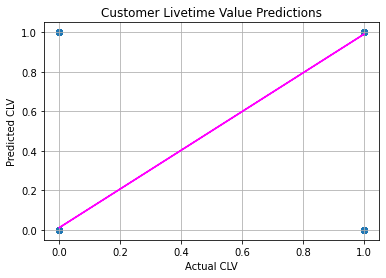

In [44]:
# Define preprocessing for numeric columns (scale them)
num_features = list(np.arange(0,7))
numeric_transformer = Pipeline(steps=[('scaler', RobustScaler(quantile_range=(10,90)))])

# Define preprocessing for categorical features (encode them)
categorical_features = np.arange(7,X.shape[1])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(sparse=True, drop='first', handle_unknown='ignore'))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, categorical_features)])

# Create preprocessing and training pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', XGBClassifier())])

model = pipeline.fit(X_train, y_train)
print(model)

# get predictions
predictions = model.predict(X_test)
pred_scores = model.predict_proba(X_test)[:,1]

# Evaluate the model using the test data
accuracy = accuracy_score(y_test, predictions)
recall = recall_score(y_test, predictions)
precision = precision_score(y_test, predictions)
auc = roc_auc_score(y_test, pred_scores)
print("Accuracy Score:", accuracy)
print("Recall Score:", recall)
print("Precision Score:", precision)
print("AUC Score:", auc)

# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual CLV')
plt.ylabel('Predicted CLV')
plt.title('Customer Livetime Value Predictions')

# overlay the regression line
z = np.polyfit(y_test.reshape(-1), predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.grid('on')
plt.show()

In [45]:
# Print the confusion matrix
mcm = confusion_matrix(y_test, predictions)
print(mcm)

[[3613   42]
 [  39 3614]]


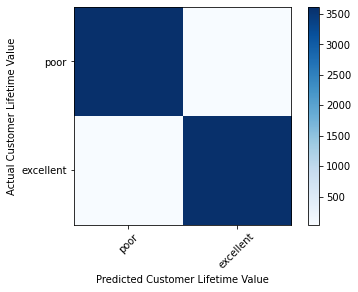

In [46]:
%matplotlib inline

clv_classes = ['poor', 'excellent']

plt.imshow(mcm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(clv_classes))
plt.xticks(tick_marks, clv_classes, rotation=45)
plt.yticks(tick_marks, clv_classes)
plt.xlabel("Predicted Customer Lifetime Value")
plt.ylabel("Actual Customer Lifetime Value")
plt.show()

# Model Fairness

In [47]:
# show version
!pip show fairlearn

Name: fairlearn
Version: 0.7.0
Summary: Algorithms for mitigating unfairness in supervised machine learning
Home-page: https://github.com/fairlearn/fairlearn
Author: Miroslav Dudik, Richard Edgar, Brandon Horn, Roman Lutz
Author-email: fairlearn@microsoft.com
License: UNKNOWN
Location: /usr/local/lib/python3.7/dist-packages
Requires: numpy, pandas, scipy, scikit-learn
Required-by: raiwidgets


In [48]:
from fairlearn.metrics  import (selection_rate, 
                                count, 
                                MetricFrame)

In [49]:
y_pred = model.predict(X_test)

In [50]:
sensitive_features

['Gender']

In [51]:
# Get metrics by sensitive group from fairlearn
print('\nMetrics by Group:')
metrics = {'Count': count,
           'Selection Rate': selection_rate}

selection_rates = MetricFrame(metrics=metrics,
                             y_true=y_test,
                             y_pred=y_pred,
                             sensitive_features=X_test[['Gender','Marital Status']])

print(selection_rates.by_group)


Metrics by Group:
                      Count Selection Rate
Gender Marital Status                     
0.0    0.0              564       0.514184
       1.0             2234       0.495524
       2.0              904       0.493363
1.0    0.0              530       0.509434
       1.0             2033       0.508116
       2.0             1043       0.488974


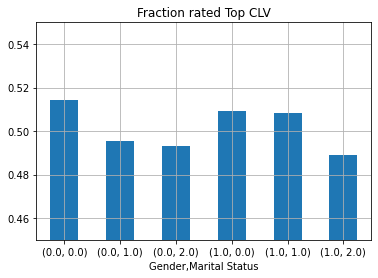

In [52]:
fig = selection_rates.by_group['Selection Rate'].plot.bar(
    legend=False, rot=0,
    title='Fraction rated Top CLV')
plt.ylim(.45,.55)
plt.grid('on')
plt.show()

In [53]:
from raiwidgets import FairnessDashboard

# View this model in Fairlearn's fairness dashboard, and see the disparities which appear:
FairnessDashboard(sensitive_features=X_test[sensitive_features],
                   y_true=y_test,
                   y_pred={"CLV_model": model.predict(X_test)})

Output hidden; open in https://colab.research.google.com to view.

# Mitigate Unfairness

In [54]:
# mitigate unfairness
from fairlearn.reductions import GridSearch, DemographicParity, ErrorRate
from sklearn.calibration import CalibratedClassifierCV

In [55]:
sweep = GridSearch(LGBMClassifier(),
                   constraints=DemographicParity(),
                   grid_size=20,
                   grid_limit=200)

sweep.fit(X_train, 
          y_train, 
          sensitive_features=X_train['Marital Status'])

predictors = sweep.predictors_

/usr/local/lib/python3.7/dist-packages/fairlearn/reductions/_moments/utility_parity.py:251: FutureWarning:

Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().

/usr/local/lib/python3.7/dist-packages/fairlearn/reductions/_moments/utility_parity.py:251: FutureWarning:

Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().

/usr/local/lib/python3.7/dist-packages/fairlearn/reductions/_moments/utility_parity.py:251: FutureWarning:

Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().

/usr/local/lib/python3.7/dist-packages/fairlearn/reductions/_moments/utility_parity.py:251: FutureWa

In [56]:
calibrated_predictors = []
for predictor in sweep.predictors_:
    calibrated = CalibratedClassifierCV(base_estimator=predictor, cv='prefit', method='sigmoid')
    calibrated.fit(X_train, y_train)
    calibrated_predictors.append(calibrated)

In [57]:
calibrated_predictors

[CalibratedClassifierCV(base_estimator=LGBMClassifier(), cv='prefit'),
 CalibratedClassifierCV(base_estimator=LGBMClassifier(), cv='prefit'),
 CalibratedClassifierCV(base_estimator=LGBMClassifier(), cv='prefit'),
 CalibratedClassifierCV(base_estimator=LGBMClassifier(), cv='prefit'),
 CalibratedClassifierCV(base_estimator=LGBMClassifier(), cv='prefit'),
 CalibratedClassifierCV(base_estimator=LGBMClassifier(), cv='prefit'),
 CalibratedClassifierCV(base_estimator=LGBMClassifier(), cv='prefit'),
 CalibratedClassifierCV(base_estimator=LGBMClassifier(), cv='prefit'),
 CalibratedClassifierCV(base_estimator=LGBMClassifier(), cv='prefit'),
 CalibratedClassifierCV(base_estimator=LGBMClassifier(), cv='prefit'),
 CalibratedClassifierCV(base_estimator=LGBMClassifier(), cv='prefit'),
 CalibratedClassifierCV(base_estimator=LGBMClassifier(), cv='prefit'),
 CalibratedClassifierCV(base_estimator=LGBMClassifier(), cv='prefit'),
 CalibratedClassifierCV(base_estimator=LGBMClassifier(), cv='prefit'),
 Calib

In [58]:
errors, disparities = [], []
for m in predictors:
    def classifier(X): return m.predict(X)

    error = ErrorRate()
    error.load_data(X_train, pd.Series(y_train.reshape(-1)), sensitive_features=X_train['Marital Status'])
    disparity = DemographicParity()
    disparity.load_data(X_train, pd.Series(y_train.reshape(-1)), sensitive_features=X_train['Marital Status'])

    errors.append(error.gamma(classifier)[0])
    disparities.append(disparity.gamma(classifier).max())

all_results = pd.DataFrame({"predictor": predictors, "error": errors, "disparity": disparities})

non_dominated = []
for row in all_results.itertuples():
    errors_for_lower_or_eq_disparity = all_results["error"][all_results["disparity"] <= row.disparity]
    if row.error <= errors_for_lower_or_eq_disparity.min():
        non_dominated.append(row.predictor)

In [59]:
unmitigated_predictor = LGBMClassifier()
unmitigated_predictor.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



LGBMClassifier()

In [60]:
from sklearn.metrics import accuracy_score

accuracy          0.988916
selection_rate         0.5
count                 7308
dtype: object
                accuracy selection_rate count
Marital Status                               
0.0             0.980804       0.519196  1094
1.0              0.99086       0.499648  4267
2.0             0.989214       0.489985  1947


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f66b65c2e10>],
      dtype=object)

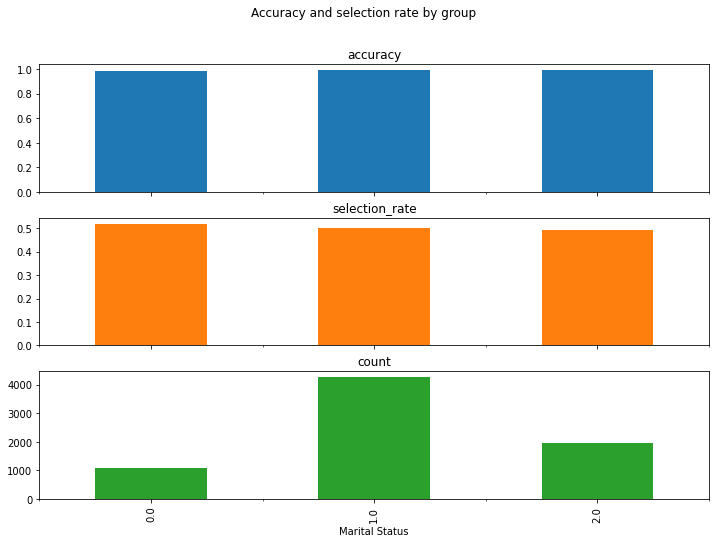

In [61]:
metric_frame = MetricFrame(metrics={"accuracy": accuracy_score,
                                    "selection_rate": selection_rate,
                                    "count": count},
                           sensitive_features=X_test['Marital Status'],
                           y_true=y_test,
                           y_pred=unmitigated_predictor.predict(X_test))
print(metric_frame.overall)
print(metric_frame.by_group)
metric_frame.by_group.plot.bar(
        subplots=True, layout=[3, 1], legend=False, figsize=[12, 8],
        title='Accuracy and selection rate by group')

Text(0, 0.5, 'selection rate difference')

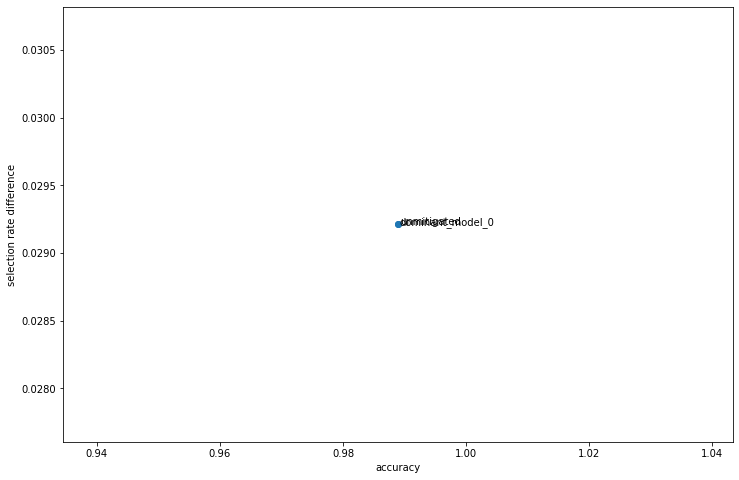

In [62]:


predictions = {"unmitigated": unmitigated_predictor.predict(X_test)}
metric_frames = {"unmitigated": metric_frame}
for i in range(len(non_dominated)):
    key = "dominant_model_{0}".format(i)
    predictions[key] = non_dominated[i].predict(X_test)

    metric_frames[key] = MetricFrame(metrics={"accuracy": accuracy_score,
                                              "selection_rate": selection_rate,
                                              "count": count},
                                     sensitive_features=X_test['Marital Status'],
                                     y_true=y_test,
                                     y_pred=predictions[key])

import matplotlib.pyplot as plt
x = [metric_frame.overall['accuracy'] for metric_frame in metric_frames.values()]
y = [metric_frame.difference()['selection_rate'] for metric_frame in metric_frames.values()]
keys = list(metric_frames.keys())
plt.figure(figsize=(12,8))
plt.scatter(x, y)
for i in range(len(x)):
    plt.annotate(keys[i], (x[i] + 0.0003, y[i]))
plt.xlabel("accuracy")
plt.ylabel("selection rate difference")

# ToDo

In [63]:
# pipeline verträgliches onehotencoding-------------ok
# danach pca
# erst verschiedene modelle testen und das beste hyperparameter tunen
# pipeline aufbauen
# explainability
# fairness